In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from lib import *

In [2]:
# only human host
df_t = load_iedb_tcellepitopes(human_only=True)
print(df_t.shape[0])

248879


In [4]:
row['iedbname']

'Plasmodium falciparum'

In [3]:
# only MHC I epitopes
df_t = df_t[(df_t['MHC', 'Class']=='I') | (pd.isna(df_t['MHC', 'Class']))]
print(df_t.shape[0])

142895


In [4]:
# only epitopes of lengths in k
mask = df_t['Epitope', 'Description'].apply(len)==9
df_t = df_t[mask]
print(df_t.shape[0])

38609


In [5]:
# restric to Malaria ('Plasmodium falciparum')
pathogenproteomes = load_proteomes(only_pathogens=True)
row = pathogenproteomes.loc['Malaria']
malaria_name = row['iedbname']
malaria_path = datadir + row['path']
df_t = df_t[df_t['Epitope', 'Parent Species'].str.contains(malaria_name, na=False)]
print(df_t.shape[0])

232


In [6]:
# restrict to ELISPOT assay?
mask = df_t['Assay', 'Method/Technique'] == 'ELISPOT'
elispot_df_t = df_t[mask]
print(elispot_df_t.shape[0])

116


In [7]:
# positive
mask = df_t[('Assay', 'Qualitative Measure')] == 'Positive'
neg_mask = df_t[('Assay', 'Qualitative Measure')] == 'Negative'
positive = df_t[mask]
negative = df_t[neg_mask]
print(positive.shape[0])
print(negative.shape[0])

151
81


In [8]:
# positive with only ELISPOT
mask = elispot_df_t[('Assay', 'Qualitative Measure')] == 'Positive'
neg_mask = elispot_df_t[('Assay', 'Qualitative Measure')] == 'Negative'
positive_elispot = elispot_df_t[mask]
negative_elispot = elispot_df_t[neg_mask]
print(positive_elispot.shape[0])
print(negative_elispot.shape[0])

60
56


In [9]:
# Malaria Epitopes
epi_t = positive['Epitope', 'Description'].unique()
positive.shape

(151, 144)

In [10]:
# Malaria Epitopes
epi_t_elispot = positive_elispot['Epitope', 'Description'].unique()
positive_elispot.shape

(60, 144)

In [11]:
positive_elispot.loc[371886]

Reference       Assay IRI                                http://www.iedb.org/assay/6477114
                Reference IRI                        http://www.iedb.org/reference/1036317
                Type                                                            Literature
                PubMed ID                                                       32040522.0
                Authors                  Kwadwo A Kusi; Felix E Aggor; Linda E Amoah; D...
                                                               ...                        
Assay Antigen   Organism Species Name                                Plasmodium falciparum
                Organism Species IRI         http://purl.obolibrary.org/obo/NCBITaxon_5833
Assay Comments  Assay Comments                                                         NaN
Assay           Positive                                                              True
Epitope         Length                                                                   9

In [12]:
names = list(positive['Assay Antigen', 'Protein Parent Name'])
names = [name.split(" ")[0] for name in names if not pd.isna(name)]

In [13]:
names_elispot = list(positive_elispot['Assay Antigen', 'Protein Parent Name'])
names_elispot = [name.split(" ")[0] for name in names_elispot if not pd.isna(name)]

In [14]:
count = 0
whitelist = set(names)
whitelist_elispot = set(names_elispot)
seqs = []
seqs_elispot = []
for header, seq in fasta_iter(malaria_path, returnheader=True):
    if header in whitelist:
        seqs.append(seq)
    if header in whitelist_elispot:
        seqs_elispot.append(seq)

In [15]:
malaria_epitope_source_proteins = set(count_kmers_iterable(seqs, 9, clean=True))
malaria_epitope_source_proteins_elispot = set(count_kmers_iterable(seqs_elispot, 9, clean=True))

In [16]:
selfset = set(count_kmers_proteome(human, 9, clean=True))

In [17]:
malaria_fullset = set(count_kmers_proteome(malaria_path, 9, clean=True))

In [18]:
self_kmers = list(selfset)
malaria_kmers = list(malaria_fullset)

malaria_epitope_kmers = list(epi_t)
malaria_epitope_source_kmers = list(malaria_epitope_source_proteins)
malaria_epitope_source_kmers = [m for m in malaria_epitope_source_kmers if m not in epi_t]


malaria_epitope_kmers_elispot = list(epi_t_elispot)
malaria_epitope_source_kmers_elispot = list(malaria_epitope_source_proteins_elispot)
malaria_epitope_source_kmers_elispot = [m for m in malaria_epitope_source_kmers_elispot if m not in epi_t_elispot]

In [18]:
# writing kmers to file to run MHC on them...
# uncomment to run

prefix = "/data/lareauc/levinej/pep/peptidome/code/maxent/data/netMHC_input/net_mhc_input_"

file_to_kmers = {
    f"{prefix}self_kmers.txt": self_kmers,
    f"{prefix}malaria_proteome_kmers.txt": malaria_kmers,
    f"{prefix}malaria_epitope_kmers.txt": malaria_epitope_kmers,
    f"{prefix}malaria_epitope_kmers_elispot.txt": malaria_epitope_kmers_elispot,
    f"{prefix}malaria_epitope_source_kmers.txt": malaria_epitope_source_kmers,
    f"{prefix}malaria_epitope_source_kmers_elispot.txt": malaria_epitope_source_kmers_elispot,
}

# for _f, km_list in file_to_kmers.items():
#     with open(_f,"w") as f:
#         for km in km_list:
#             f.write(f"{km}\n")

In [19]:
cache = {
    "self_kmers": {},
    "malaria_proteome_kmers": {},
    "malaria_epitope_kmers": {},
    "malaria_epitope_kmers_elispot": {},
    "malaria_epitope_source_kmers": {},
    "malaria_epitope_source_kmers_elispot": {}
    
}

In [20]:
def get_mhc_df(model, allele):
    try:
        return pd.read_csv(f'data/netMHC_output/net_mhc_output_{model}-{allele}.csv')
    except Exception as e:
        print(f'Missing CSV: {model},{allele}')
        return None
        
def get_combined_binders(model, alleles):

    kmers = set()
    for allele in alleles:
        print(allele)
        
        if allele in cache[model]:
            kmers = kmers.union(cache[model])
            print('cache hit')
        else:
            mhc_df = get_mhc_df(model, allele)
            if mhc_df is not None:
                new_set= set(mhc_df['Peptide'])
                kmers = kmers.union(new_set)
                cache[model][allele] = new_set
                
    return kmers

In [21]:
haplotypes = pd.read_csv('/data/lareauc/levinej/pep/peptidome/code/maxent/data/top_500_allowed_haplotypes.csv')
hap_cols = ['A1','A2','B1','B2','C1','C2']

In [22]:
top_haplotype = haplotypes.loc[0][hap_cols]
list(top_haplotype)

['HLA-A0101', 'HLA-A0201', 'HLA-B0702', 'HLA-B0801', 'HLA-C0701', 'HLA-C0702']

In [23]:
top_haplotype_filtered_kmers = {}

for model in cache:
    top_haplotype_filtered_kmers[model] = get_combined_binders(model, top_haplotype)
    

HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702


In [71]:
from lib.maxent import *
energy = make_energy(np.load(f'data/Human_nskewfcov_k9_params.npz'))

In [25]:

F = float(pd.read_csv(f'../maxent/data/Human_nskewfcov_k9_entropy.csv',header=None, index_col=0).loc['F'].values[0])
loglikelihood  = lambda seq: -energy(seq) + F


In [72]:
human_energies = [energy(s) for s in kmers_to_matrix(self_kmers)]
malaria_energies = [energy(s) for s in kmers_to_matrix(malaria_kmers)]

epitope_energies = [energy(s) for s in kmers_to_matrix(malaria_epitope_kmers)]
epitope_source_energies = [energy(s) for s in kmers_to_matrix(malaria_epitope_source_kmers)]

epitope_energies_elispot = [energy(s) for s in kmers_to_matrix(malaria_epitope_kmers_elispot)]
epitope_source_energies_elispot = [energy(s) for s in kmers_to_matrix(malaria_epitope_source_kmers_elispot)]

In [27]:
# human_ll = [loglikelihood(s) for s in kmers_to_matrix(self_kmers)]
# epitope_ll = [loglikelihood(s) for s in kmers_to_matrix(malaria_epitope_kmers)]
# malaria_ll = [loglikelihood(s) for s in kmers_to_matrix(malaria_kmers)]
# epitope_source_ll = [loglikelihood(s) for s in kmers_to_matrix(maria_epitope_source_kmers)]

In [28]:
human_energies_mhc = [energy(s) for s in kmers_to_matrix(top_haplotype_filtered_kmers["self_kmers"])]
malaria_energies_mhc = [energy(s) for s in kmers_to_matrix(top_haplotype_filtered_kmers["malaria_proteome_kmers"])]

# epitope_energies = [energy(s) for s in kmers_to_matrix(malaria_epitope_kmers)]

epitope_source_energies_mhc = [energy(s) for s in kmers_to_matrix(top_haplotype_filtered_kmers["malaria_epitope_source_kmers"])]

# epitope_energies_elispot = [energy(s) for s in kmers_to_matrix(malaria_epitope_kmers_elispot)]
epitope_source_energies_elispot_mhc = [energy(s) for s in kmers_to_matrix(top_haplotype_filtered_kmers["malaria_epitope_source_kmers_elispot"])]


Text(0.5, 1.0, 'ELISPOT Only (N=60 epitopes)')

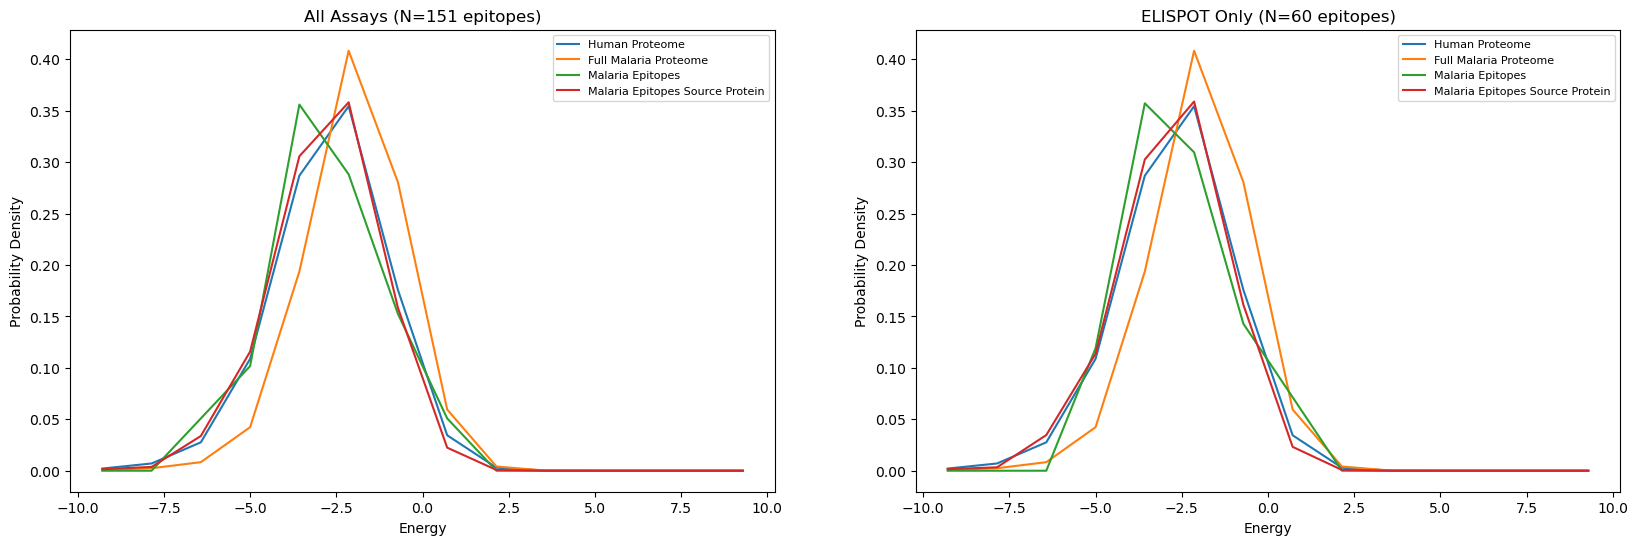

In [73]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

labels = ['Human Proteome',
          'Full Malaria Proteome',
          'Malaria Epitopes',
          'Malaria Epitopes Source Protein',
          ]
#           'Malaria Epitopes Source Protein w/o Epitopes']

for name, energy_values in zip(labels,
                               [human_energies,
                                malaria_energies,
                                epitope_energies, epitope_source_energies,
                               ]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)

plt.xlabel('Energy')
plt.ylabel('Probability Density')  
plt.legend(loc='upper right',fontsize=8)
plt.title(f'All Assays (N={positive.shape[0]} epitopes)')


plt.subplot(1,2,2)

for name, energy_values in zip(labels,
                               [human_energies,
                                malaria_energies,
                                epitope_energies_elispot, epitope_source_energies_elispot,
                                ]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)

plt.xlabel('Energy')
plt.ylabel('Probability Density')  
plt.legend(loc='upper right',fontsize=8)
plt.title(f'ELISPOT Only (N={positive_elispot.shape[0]} epitopes)')

    
# plt.subplot(1,2,2)
# likes = [np.array(vec)-F for vec in [human_ll,malaria_ll,epitope_ll, epitope_source_ll]]
# # plt.bar(np.arange(4),means, width=.2)
# plt.boxplot(likes)
# plt.xticks(np.arange(4),labels,rotation=45)
# plt.ylabel('Avg Likelihood')

# plt.savefig('plots/energies_malaria_epitopes_elispot_vs.png')






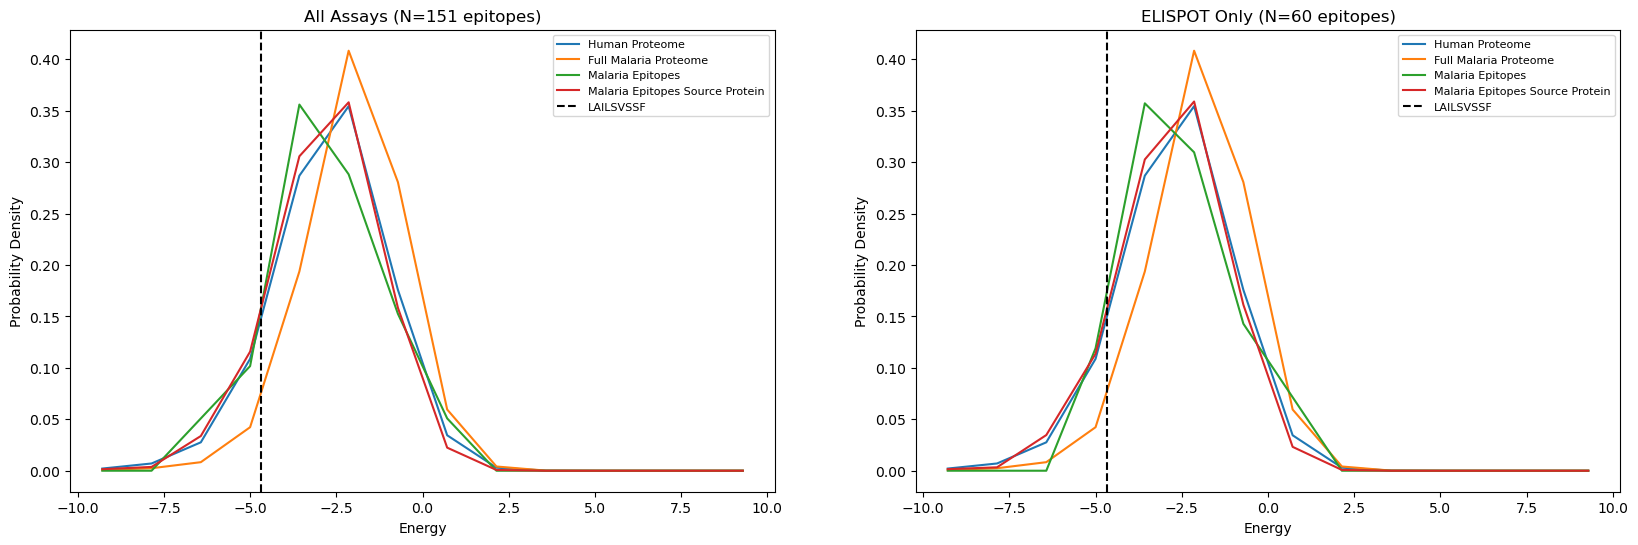

In [76]:
e1 = 'SFLFVEALF'
e2 = 'FVEALFQEY'
e3 = 'LAILSVSSF'
e4 = 'YLNKIQNSL'
example_matrix = kmers_to_matrix([e1,e2,e3,e4])
e1_energy = energy(example_matrix[0,:])
e2_energy = energy(example_matrix[1,:])
e3_energy = energy(example_matrix[2,:])
e4_energy = energy(example_matrix[3,:])


plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

labels = ['Human Proteome',
          'Full Malaria Proteome',
          'Malaria Epitopes',
          'Malaria Epitopes Source Protein']
#           'Malaria Epitopes Source Protein w/o Epitopes']

for name, energy_values in zip(labels,
                               [human_energies,malaria_energies,epitope_energies, epitope_source_energies]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)

# plt.axvline(e1_energy, color='k', linestyle='--', label=e1)
plt.axvline(e3_energy, color='k', linestyle='--', label=e3)

plt.xlabel('Energy')
plt.ylabel('Probability Density')  
plt.legend(loc='upper right',fontsize=8)
plt.title(f'All Assays (N={positive.shape[0]} epitopes)')


plt.subplot(1,2,2)

for name, energy_values in zip(labels,
                               [human_energies,malaria_energies,epitope_energies_elispot, epitope_source_energies_elispot]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)
# plt.axvline(e1_energy, color='k', linestyle='--', label=e1)
plt.axvline(e3_energy, color='k', linestyle='--', label=e3)
plt.xlabel('Energy')
plt.ylabel('Probability Density')  
plt.legend(loc='upper right',fontsize=8)
plt.title(f'ELISPOT Only (N={positive_elispot.shape[0]} epitopes)')

    
# plt.subplot(1,2,2)
# likes = [np.array(vec)-F for vec in [human_ll,malaria_ll,epitope_ll, epitope_source_ll]]
# # plt.bar(np.arange(4),means, width=.2)
# plt.boxplot(likes)
# plt.xticks(np.arange(4),labels,rotation=45)
# plt.ylabel('Avg Likelihood')

plt.savefig('plots/energies_malaria_epitopes_with_examples.png')






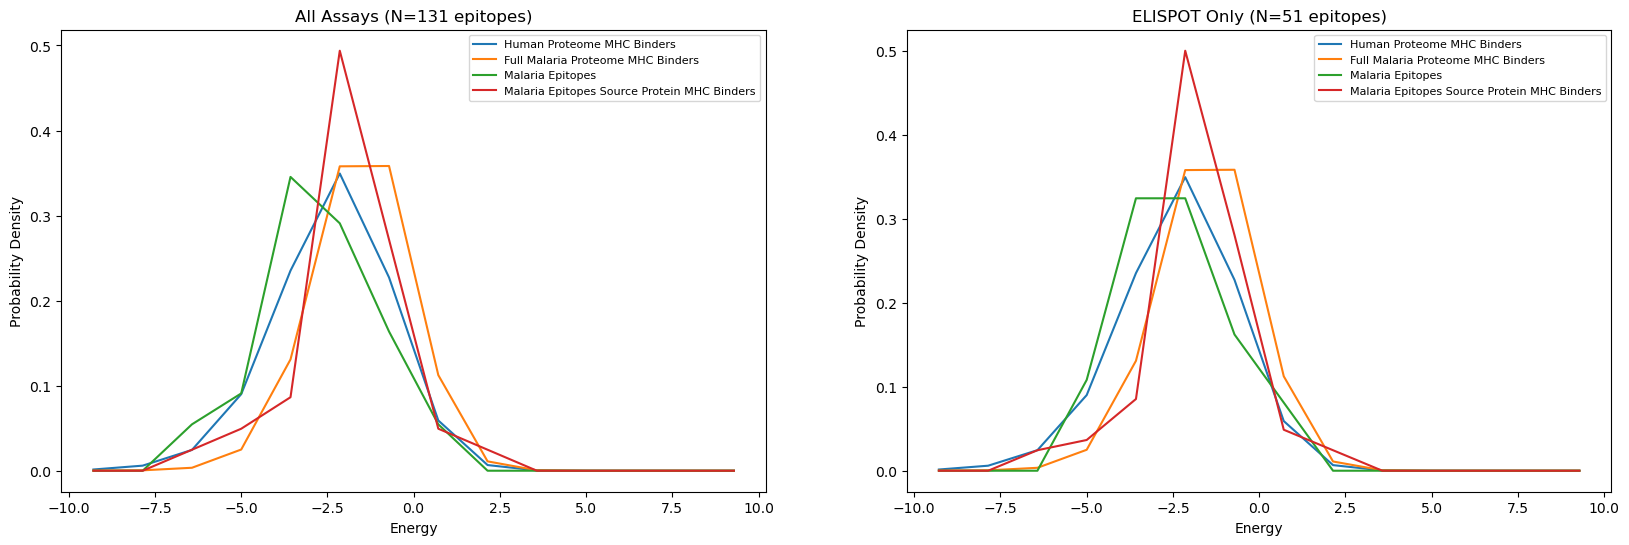

In [31]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

labels = ['Human Proteome MHC Binders',
          'Full Malaria Proteome MHC Binders',
          'Malaria Epitopes',
          'Malaria Epitopes Source Protein MHC Binders']

for name, energy_values in zip(labels,
                               [human_energies_mhc,
                                malaria_energies_mhc,
                                epitope_energies, epitope_source_energies_mhc
                               ]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)

plt.xlabel('Energy')
plt.ylabel('Probability Density')  
plt.legend(loc='upper right',fontsize=8)
plt.title(f'All Assays (N={positive.shape[0]} epitopes)')


plt.subplot(1,2,2)

for name, energy_values in zip(labels,
                               [human_energies_mhc,
                                malaria_energies_mhc,
                                epitope_energies_elispot,
                                epitope_source_energies_elispot_mhc]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)

plt.xlabel('Energy')
plt.ylabel('Probability Density')  
plt.legend(loc='upper right',fontsize=8)
plt.title(f'ELISPOT Only (N={positive_elispot.shape[0]} epitopes)')

    
# plt.subplot(1,2,2)
# likes = [np.array(vec)-F for vec in [human_ll,malaria_ll,epitope_ll, epitope_source_ll]]
# # plt.bar(np.arange(4),means, width=.2)
# plt.boxplot(likes)
# plt.xticks(np.arange(4),labels,rotation=45)
# plt.ylabel('Avg Likelihood')

plt.savefig('plots/energies_mhc_malaria_epitopes_elispot_vs.png')






NameError: name 'human_energies_mhc' is not defined

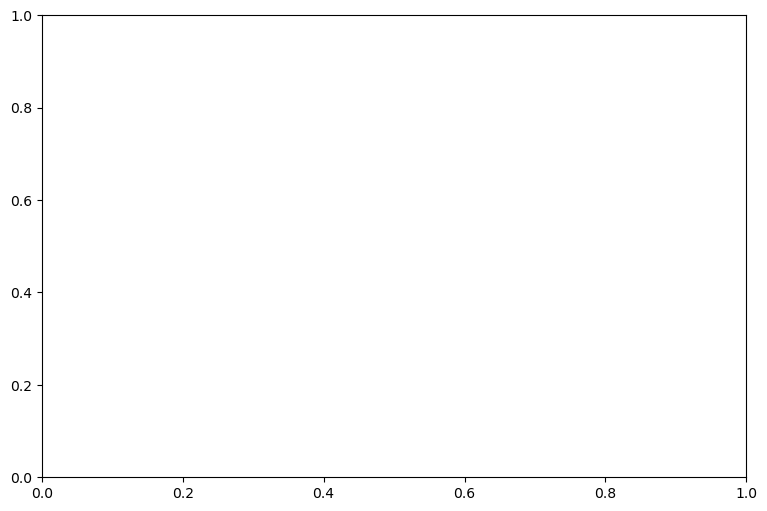

In [75]:
e1 = 'SFLFVEALF'
e2 = 'FVEALFQEY'
e3 = 'LAILSVSSF'
e4 = 'YLNKIQNSL'
example_matrix = kmers_to_matrix([e1,e2,e3,e4])
e1_energy = energy(example_matrix[0,:])
e2_energy = energy(example_matrix[1,:])
e3_energy = energy(example_matrix[2,:])
e4_energy = energy(example_matrix[3,:])


plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

labels = ['Human Proteome MHC Binders',
          'Full Malaria Proteome MHC Binders',
          'Malaria Epitopes',
          'Malaria Epitopes Source Protein MHC Binders']

for name, energy_values in zip(labels,
                               [human_energies_mhc,
                                malaria_energies_mhc,
                                epitope_energies, epitope_source_energies_mhc
                               ]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)

# plt.axvline(e1_energy, color='k', linestyle='--', label=e1)
plt.axvline(e3_energy, color='k', linestyle='--', label=e3)

plt.xlabel('Energy')
plt.ylabel('Probability Density')  
plt.legend(loc='upper right',fontsize=8)
plt.title(f'All Assays (N={positive.shape[0]} epitopes)')


plt.subplot(1,2,2)

for name, energy_values in zip(labels,
                               [human_energies_mhc,
                                malaria_energies_mhc,
                                epitope_energies_elispot,
                                epitope_source_energies_elispot_mhc]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)
# plt.axvline(e1_energy, color='k', linestyle='--', label=e1)
plt.axvline(e3_energy, color='k', linestyle='--', label=e3)
plt.xlabel('Energy')
plt.ylabel('Probability Density')  
plt.legend(loc='upper right',fontsize=8)
plt.title(f'ELISPOT Only (N={positive_elispot.shape[0]} epitopes)')

    
# plt.subplot(1,2,2)
# likes = [np.array(vec)-F for vec in [human_ll,malaria_ll,epitope_ll, epitope_source_ll]]
# # plt.bar(np.arange(4),means, width=.2)
# plt.boxplot(likes)
# plt.xticks(np.arange(4),labels,rotation=45)
# plt.ylabel('Avg Likelihood')

plt.savefig('plots/energies_mhc_malaria_epitopes_with_examples.png')






In [33]:
e3_energy
e3
#  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7010280/
#  https://malariajournal.biomedcentral.com/articles/10.1186/1475-2875-12-185/tables/7

'LAILSVSSF'

In [34]:
# plt.figure(figsize=(10,6))

# labels = ['Human Proteome',
#           'Full Malaria Proteome',
#           'Malaria Epitopes',
#           'Malaria Epitopes Source Protein']
# #           'Malaria Epitopes Source Protein w/o Epitopes']

# for name, ll_values in zip(labels,
#                                [human_ll,malaria_ll,epitope_ll, epitope_source_ll]):
# #     bins = np.linspace(-10, 10, 15)
#     count, bins_count = np.histogram(np.log10(np.exp(ll_values)),bins=50)
#     pdf = count / sum(count)
    
# #     plt.subplot(1,2,1)
#     plt.plot(0.5*(bins_count[:-1]+bins_count[1:]), pdf ,label=name)
#     plt.yscale('log')

# plt.xlabel('$log_{10}P(\sigma)$')
# plt.ylabel('Probability Density')  
# plt.legend(loc='upper right',fontsize=8)

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/scratch/lsftmp/9501900.tmpdir/ipykernel_65815/2480906670.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$log_{10}P(\sigma)$')
/scratch/lsftmp/9501900.tmpdir/ipykernel_65815/2480906670.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$log_{10}P(\sigma)$')


NameError: name 'human_ll' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
from collections import Counter as cCounter
    
def get_aa_freq(kmers):
    counts = cCounter("".join(kmers))
    denominator = len(kmers)*len(kmers[0])
    f = {letter: counts[letter]/denominator for letter in counts}
    return f
    

In [ ]:
f_malaria = get_aa_freq(malaria_kmers)
f_epitopes = get_aa_freq(malaria_epitope_kmers)
f_epitopes_elispot = get_aa_freq(malaria_epitope_kmers_elispot)
f_epitopes_source = get_aa_freq(malaria_epitope_source_kmers)
f_epitopes_elispot_source = get_aa_freq(malaria_epitope_source_kmers_elispot)

In [ ]:
f_human = get_aa_freq(self_kmers)

In [ ]:
ssr_malaria = sum((f_human[aa] - f_malaria[aa])**2 for aa in f_human)
ssr_epitopes = sum((f_human[aa] - f_epitopes[aa])**2 for aa in f_human)
ssr_epitopes_elispot = sum((f_human[aa] - f_epitopes_elispot[aa])**2 for aa in f_human)
ssr_epitopes_source = sum((f_human[aa] - f_epitopes_source[aa])**2 for aa in f_human)
ssr_epitopes_elispot_source = sum((f_human[aa] - f_epitopes_elispot_source[aa])**2 for aa in f_human)

In [ ]:
ssr_malaria

In [ ]:
ssr_epitopes

In [ ]:
fontsize=8

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(6,5),sharex=True)
x = [f_human[aa] for aa in f_human]
y1 = [f_malaria[aa] for aa in f_human]
y2 = [f_epitopes[aa] for aa in f_human]
y3 = [f_epitopes_source[aa] for aa in f_human]

ax1.scatter(x, y1, color='b', s=8,label='Full Malaria Proteome')
ax2.scatter(x, y2, color='b', s=8,label='Malaria Epitopes')
ax3.scatter(x, y3, color='b', s=8,label='Malaria Epitopes Source Proteins')


def random_jiggle(x,y):
    r1 = np.random.random() - 0.5
    r1 *= .0015
    r2 = np.random.random() - 0.5
    r2 *= .0015
    
    return (x+r1,y+r2)

for aa in f_human:
    ax1.annotate(aa, random_jiggle(f_human[aa],f_malaria[aa]),fontsize=fontsize)
    ax2.annotate(aa, random_jiggle(f_human[aa],f_epitopes[aa]),fontsize=fontsize)
    ax3.annotate(aa, random_jiggle(f_human[aa],f_epitopes_source[aa]),fontsize=fontsize)

ax1.annotate("SSR: %.5f" % ssr_malaria, (.020, .185),fontsize=fontsize)
ax2.annotate("SSR: %.5f" % ssr_epitopes, (.020, .185),fontsize=fontsize)
ax3.annotate("SSR: %.5f" % ssr_epitopes_source, (.020, .185),fontsize=fontsize)

ax1.plot([0,.12],[0,.2], 'k--')
ax2.plot([0,.12],[0,.2], 'k--')
ax3.plot([0,.15],[0,.2], 'k--')
ax3.set_xlim([0,.12])
# ax1.set_xlabel('Human Proteome AA Frequency',fontsize=16)
# ax2.set_xlabel('Human Proteome AA Frequency',fontsize=16)
ax3.set_xlabel('AA Frequency Human Proteome',fontsize=fontsize)

ax1.set_ylabel('AA Frequency \n Malaria Proteome',fontsize=fontsize)
ax2.set_ylabel('AA Frequency \n Malaria Epitopes',fontsize=fontsize)
ax3.set_ylabel('AA Frequency \n Malaria Epitopes \n Source Proteins',fontsize=fontsize)
ax1.set_title(f'All Assays (N={positive.shape[0]} epitopes)',fontsize=fontsize+2)

plt.savefig('plots/aa_freq_malaria.png')

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(6,5),sharex=True)
x = [f_human[aa] for aa in f_human]
y1 = [f_malaria[aa] for aa in f_human]
y2 = [f_epitopes_elispot[aa] for aa in f_human]
y3 = [f_epitopes_elispot_source[aa] for aa in f_human]

ax1.scatter(x, y1, color='b', s=8,label='Full Malaria Proteome')
ax2.scatter(x, y2, color='b', s=8,label='Malaria Epitopes')
ax3.scatter(x, y3, color='b', s=8,label='Malaria Epitopes Source Proteins')


def random_jiggle(x,y):
    r1 = np.random.random() - 0.5
    r1 *= .0015
    r2 = np.random.random() - 0.5
    r2 *= .0015
    
    return (x+r1,y+r2)

for aa in f_human:
    ax1.annotate(aa, random_jiggle(f_human[aa],f_malaria[aa]),fontsize=fontsize)
    ax2.annotate(aa, random_jiggle(f_human[aa],f_epitopes_elispot[aa]),fontsize=fontsize)
    ax3.annotate(aa, random_jiggle(f_human[aa],f_epitopes_elispot_source[aa]),fontsize=fontsize)

ax1.annotate("SSR: %.5f" % ssr_malaria, (.020, .185),fontsize=fontsize)
ax2.annotate("SSR: %.5f" % ssr_epitopes_elispot, (.020, .185),fontsize=fontsize)
ax3.annotate("SSR: %.5f" % ssr_epitopes_elispot_source, (.020, .185),fontsize=fontsize)

ax1.plot([0,.12],[0,.2], 'k--')
ax2.plot([0,.12],[0,.2], 'k--')
ax3.plot([0,.15],[0,.2], 'k--')
ax3.set_xlim([0,.12])
# ax1.set_xlabel('Human Proteome AA Frequency',fontsize=16)
# ax2.set_xlabel('Human Proteome AA Frequency',fontsize=16)
ax3.set_xlabel('AA Frequency Human Proteome',fontsize=fontsize)

ax1.set_ylabel('AA Frequency \n Malaria Proteome',fontsize=fontsize)
ax2.set_ylabel('AA Frequency \n Malaria Epitopes',fontsize=fontsize)
ax3.set_ylabel('AA Frequency \n Malaria Epitopes \n Source Proteins',fontsize=fontsize)

ax1.set_title(f'ELISPOT Only (N={positive_elispot.shape[0]} epitopes)',fontsize=fontsize+2)


plt.savefig('plots/aa_freq_elispot_malaria.png')

In [ ]:
def subcategorybar(X, vals, clist, labellist):
    width=0.5
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i].values(), 
                width=width/float(n), align="edge", color=clist[i], label=labellist[i])   
    plt.xticks(_X, X)
    plt.legend(loc='upper right')

aminoacids = 'ACDEFGHIKLMNPQRSTVWY'
plt.figure(figsize=(20,7))
subcategorybar(list(aminoacids), [f_human, f_malaria, f_epitopes],
              ['r', 'orange', 'b'], 
               ['human proteome', 'malaria proteome', 'malaria epitopes'])
plt.ylabel('Frequency')
plt.xlabel('Amino Acids')
plt.title('Amino Acid Distributions')
# plt.savefig('./Figures/peptides/aa_distributions.pdf')


In [114]:
reference = selfset
def mat_to_dist(A, size=100000):
    if A.shape[0] > size:
        sample = matrix_to_kmers(A[np.random.choice(A.shape[0], size=size, replace=False), :])
    else:
        sample = matrix_to_kmers(A)
    ns = nndist_hamming_distribution(sample, reference)
    return ns

In [115]:
print("--")
malaria_ns = mat_to_dist(kmers_to_matrix(malaria_kmers))
print("--")
epitope_ns = mat_to_dist(kmers_to_matrix(malaria_epitope_kmers))
print("--")
epitope_source_ns = mat_to_dist(kmers_to_matrix(malaria_epitope_source_kmers))
print("--")

epitope_ns_elispot = mat_to_dist(kmers_to_matrix(malaria_epitope_kmers_elispot))
print("--")
epitope_source_ns_elispot = mat_to_dist(kmers_to_matrix(malaria_epitope_source_kmers_elispot))

--
--
--
--
--


In [116]:
random_ns = mat_to_dist(np.random.choice(np.arange(0, 20, 1), size=(100000,9)))

In [25]:
np.random.choice(np.arange(0, 20, 1), size=(2,9))


array([[ 3,  8, 18,  9, 12,  4, 13,  6,  3],
       [ 7,  9, 18,  2,  6,  0,  8, 14,  0]])

In [22]:
def serialize_int_arr(arr):
    return [int(x) for x in arr]

In [118]:
save_data = {
    'malaria': serialize_int_arr(malaria_ns),
    'epitopes': serialize_int_arr(epitope_ns),
    'epitope_source': serialize_int_arr(epitope_source_ns),
    'epitope_elispot': serialize_int_arr(epitope_ns_elispot),
    'epitope_source_elispot': serialize_int_arr(epitope_source_ns_elispot),
    'null': serialize_int_arr(random_ns)
    
}

with open('./data/malaria_distance_to_self.json','w') as f:
    json.dump(save_data, f)

In [26]:
with open('./data/malaria_distance_to_self.json','r') as f:
    distances_data = json.load(f)

In [27]:
distances_data

{'malaria': [325, 2236, 37932, 59507],
 'epitopes': [0, 3, 28, 28],
 'epitope_source': [0, 129, 2100, 1831],
 'epitope_elispot': [0, 1, 21, 20],
 'epitope_source_elispot': [0, 127, 2011, 1785],
 'null': [1, 365, 18931, 80703]}

In [33]:
d_v = np.array(distances_data['null'])
d_v = d_v/sum(d_v)
d_v


array([1.0000e-05, 3.6500e-03, 1.8931e-01, 8.0703e-01])

In [30]:
malaria_ns = distances_data['malaria']
epitope_ns = distances_data['epitopes']
epitope_source_ns = distances_data['epitope_source']
epitope_ns_elispot = distances_data['epitope_elispot']

epitope_source_ns_elispot = distances_data['epitope_source_elispot']
random_ns = distances_data['null']

Text(0.5, 0, 'Distance to nearest self peptide')

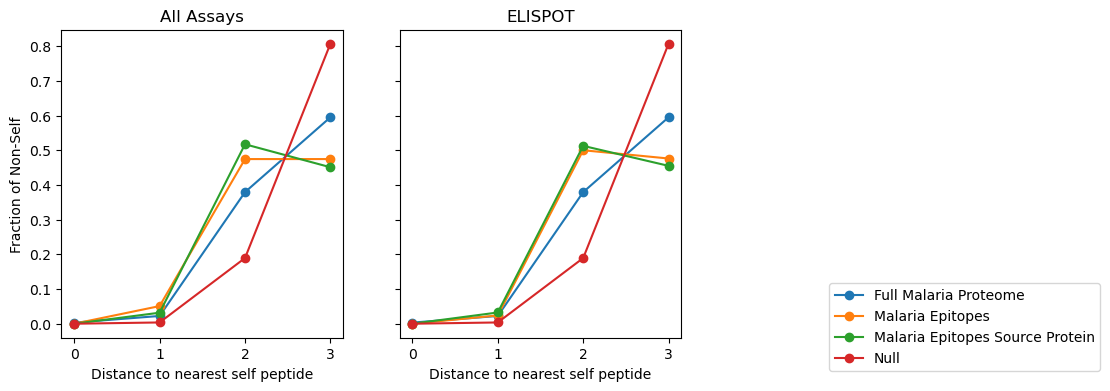

In [31]:
fig, [ax1,ax2] = plt.subplots(figsize=(8, 4), ncols=2, sharey=True)

labels = [
          'Full Malaria Proteome',
          'Malaria Epitopes',
          'Malaria Epitopes Source Protein',
          'Null']
for name, _ns in zip(labels,[malaria_ns, epitope_ns, epitope_source_ns, random_ns]):
    ns = np.array(_ns)
    ps = ns/sum(ns)
    
    ax1.plot(range(4), ps, '-o', label=name)

for name, _ns in zip(labels,[malaria_ns, epitope_ns_elispot, epitope_source_ns_elispot,random_ns]):
    ns = np.array(_ns)
    ps = ns/sum(ns)
    
    ax2.plot(range(4), ps, '-o', label=name)
    
# ax1.set_yscale('log')
ax1.set_title('All Assays')
ax2.set_title('ELISPOT')
ax2.legend(loc='upper left',bbox_to_anchor=(1.5,.2))
ax1.set_ylabel('Fraction of Non-Self')
ax1.set_xlabel('Distance to nearest self peptide')
ax2.set_xlabel('Distance to nearest self peptide')

# ax1.set_ylim(10e-10, 1.1)
# ax1.set_yticks(10**np.arange(-3.0, 1.0, 1.0))
# ax2.set_ylim(10e-5, 1.1)
# ax2.set_yticks(10**np.arange(-3.0, 1.0, 1.0))

In [122]:
ps

array([1.0000e-05, 3.6500e-03, 1.8931e-01, 8.0703e-01])

In [193]:
epitope_source_ns

array([   0,  131, 2124, 1855])

In [53]:
import pyrepseq as prs

In [55]:
prs.nndist_hamming(e1, selfset, maxdist=4)

3

In [56]:
prs.nndist_hamming(e2, selfset, maxdist=4)

3

In [57]:
prs.nndist_hamming(e3, selfset, maxdist=4)

1

In [58]:
prs.nndist_hamming(e4, selfset, maxdist=4)

2

In [36]:
d1

{'Malaria Peptidome': np.float64(0.02236),
 'Malaria Epitopes': np.float64(0.05084745762711865),
 'Null Model': np.float64(0.00365)}

In [34]:
# distance one
d1 = {}
d2 = {}
d3 = {}

labels = [
          'Malaria Peptidome',
          'Malaria Epitopes',
          'Null Model']
for name, _ns in zip(labels,[malaria_ns, epitope_ns,random_ns]):
    ns = np.array(_ns)
    ps = ns/sum(ns)
    d1[name] = ps[1]
    d2[name] = ps[2]
    d3[name] = ps[3]

In [37]:
rows = []
for name, _ns in zip(labels,[malaria_ns, epitope_ns,random_ns]):
    ns = np.array(_ns)
    ps = ns/sum(ns)
    for i in range(4):
        rows.append({
            'distance_bin': i,
            'source': name,
            'value': ps[i]
    })

distances_df = pd.DataFrame(columns=['distance_bin','source','value'],data=rows)

In [38]:
distances_df['distance'] = distances_df['distance_bin'].apply(lambda x: f"{x}" if x < 3 else f"{x}+")

In [39]:
distances_df

,distance_bin,source,value,distance
0,0,Malaria Peptidome,0.003250,0
1,1,Malaria Peptidome,0.022360,1
2,2,Malaria Peptidome,0.379320,2
3,3,Malaria Peptidome,0.595070,3+
4,0,Malaria Epitopes,0.000000,0
5,1,Malaria Epitopes,0.050847,1
6,2,Malaria Epitopes,0.474576,2
7,3,Malaria Epitopes,0.474576,3+
8,0,Null Model,0.000010,0
9,1,Null Model,0.003650,1


Text(0, 0.5, 'Fraction')

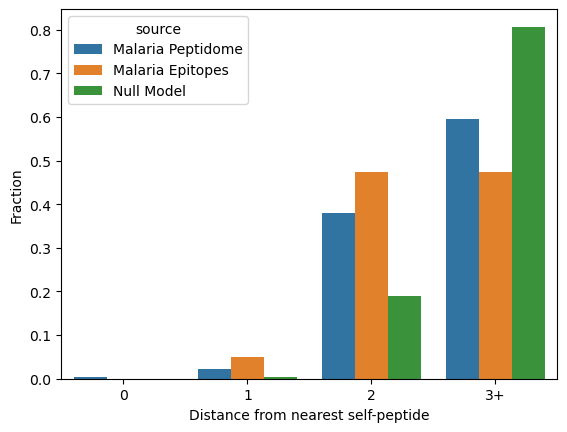

In [40]:
import seaborn as sns
sns.barplot(distances_df, x='distance', y='value', hue='source')
plt.xlabel('Distance from nearest self-peptide')
plt.ylabel('Fraction')

Text(0, 0.5, 'Fraction at dist=1')

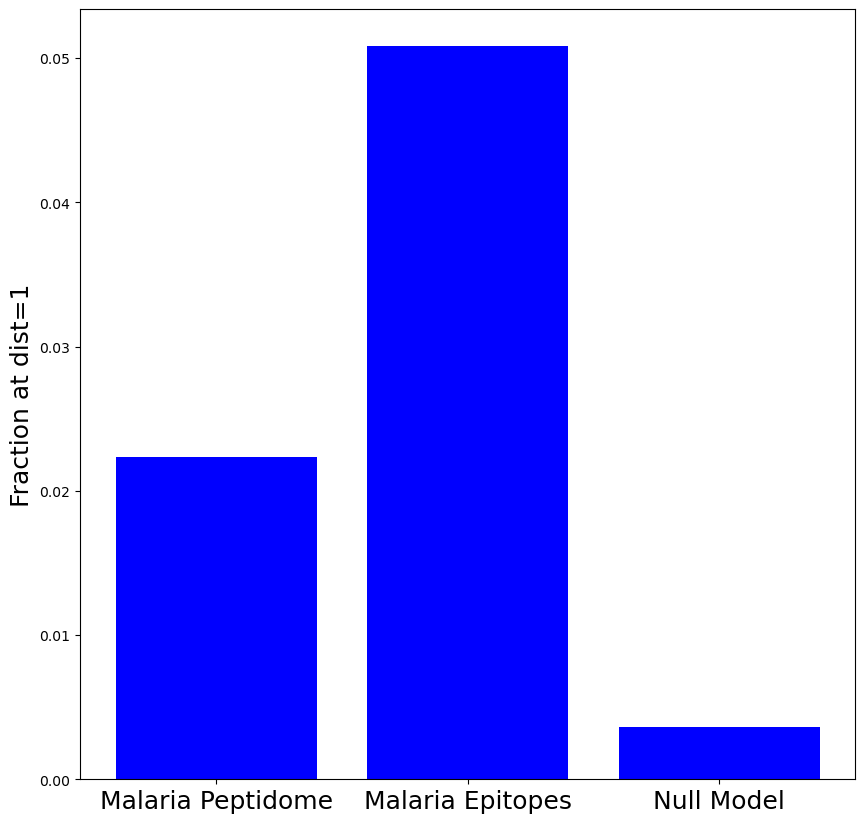

In [41]:
plt.figure(figsize=(10,10))
plt.bar(d1.keys(),d1.values(),color='blue')
plt.xticks(fontsize=18)
plt.ylabel('Fraction at dist=1',fontsize=18)
# plt.title('Malaria Epitopes are Closer to Self Than Expected',fontsize=18)

Text(0, 0.5, 'Fraction at dist=2')

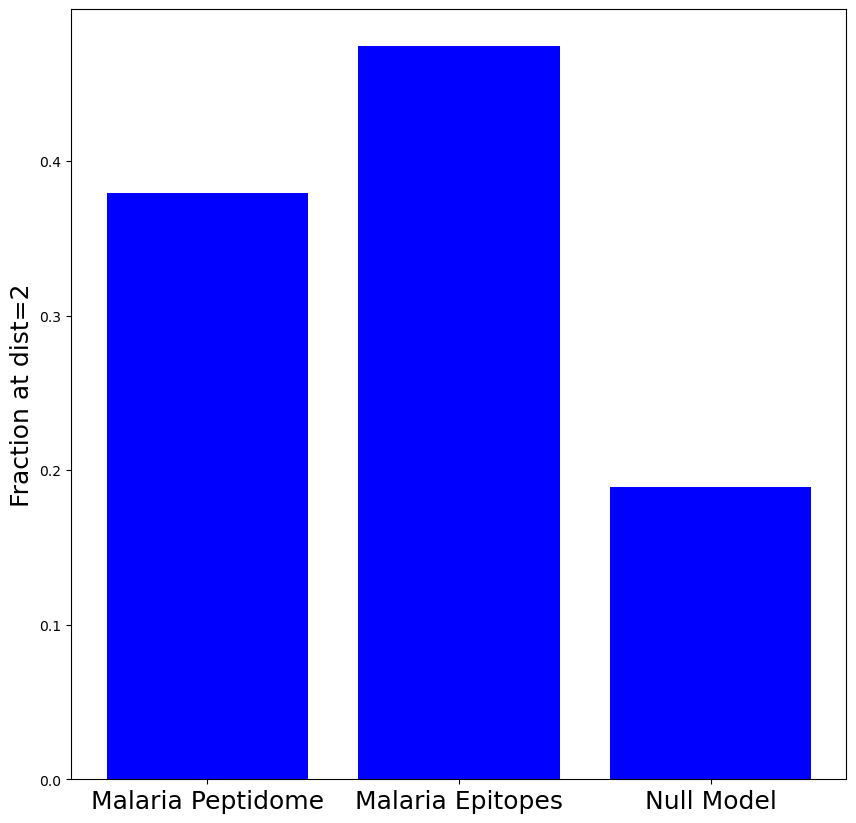

In [42]:
plt.figure(figsize=(10,10))
plt.bar(d2.keys(),d2.values(),color='blue')
plt.xticks(fontsize=18)
plt.ylabel('Fraction at dist=2',fontsize=18)

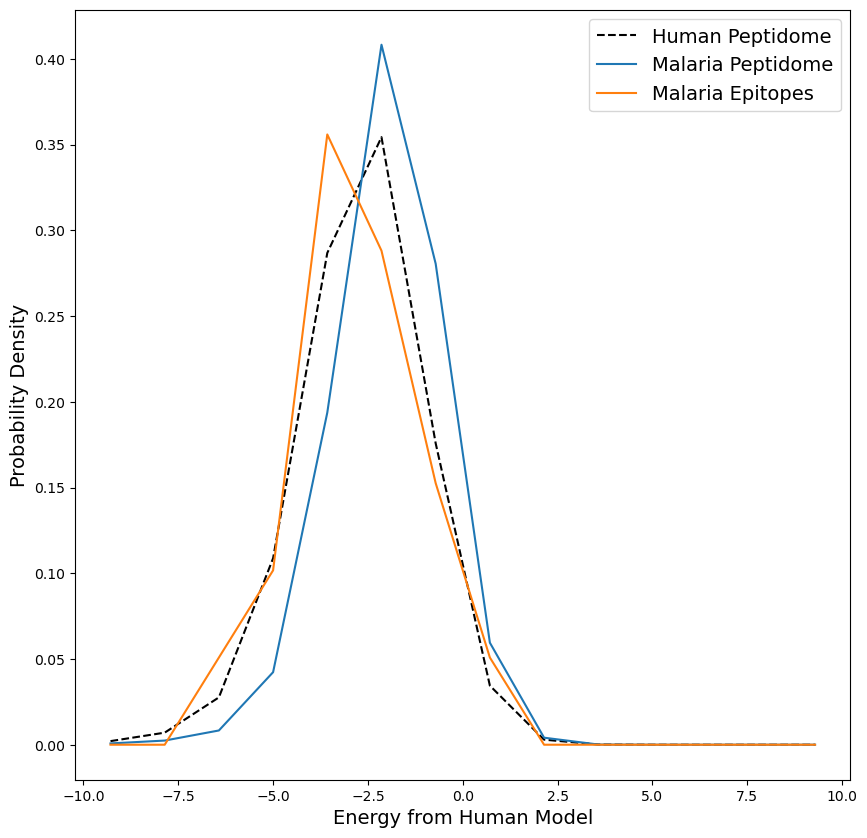

In [78]:
plt.figure(figsize=(10,10))
labels = ['Human Peptidome',
          'Malaria Peptidome',
          'Malaria Epitopes',
         ]
for name, energy_values in zip(labels,
                               [human_energies,
                                malaria_energies,
                                epitope_energies
                               ]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    if name.startswith('Human'):
        plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,'k--',label=name)
    else:
        plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)

# plt.axvline(e1_energy, color='k', linestyle='--', label=e1)
# plt.axvline(e3_energy, color='r', linestyle='--', label=e3)

plt.xlabel('Energy from Human Model',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
plt.legend(loc='upper right',fontsize=14)
# 

In [3]:
e1 = 'SFLFVEALF'
e2 = 'FVEALFQEY'
e3 = 'LAILSVSSF'
e4 = 'YLNKIQNSL'

In [43]:
distance_one = []
for kmer in malaria_epitope_kmers:
    d = prs.nndist_hamming(kmer, selfset, maxdist=4)
    if d<2:
        print(kmer)
        distance_one.append(kmer)

GIAGGLALL
VLAGLLGNV
LAILSVSSF


In [53]:
for pep in distance_one:
    one_away = prs.levenshtein_neighbors(pep)
    for neighbor in one_away:
        if neighbor in selfset:
            print(f"Found: {neighbor}")

Found: GAAGGLALL
Found: VLAGLLGMV
Found: LGILSVSSF


In [44]:
d1_matrix = kmers_to_matrix(distance_one)

for i in range(len(distance_one)):
    print(energy(d1_matrix[i,:]))



NameError: name 'energy' is not defined

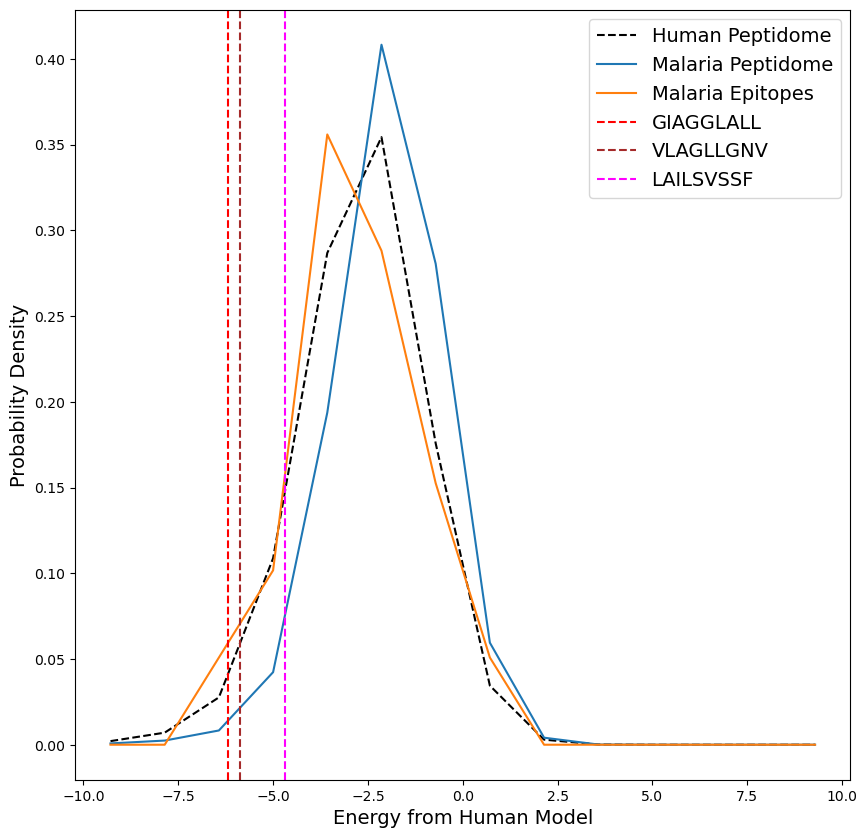

In [112]:
plt.figure(figsize=(10,10))
labels = ['Human Peptidome',
          'Malaria Peptidome',
          'Malaria Epitopes',
         ]
for name, energy_values in zip(labels,
                               [human_energies,
                                malaria_energies,
                                epitope_energies
                               ]):
    bins = np.linspace(-10, 10, 15)
    count, bins_count = np.histogram(energy_values,bins=bins)
    pdf = count / sum(count)
    
#     plt.subplot(1,2,1)
    if name.startswith('Human'):
        plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,'k--',label=name)
    else:
        plt.plot(0.5*(bins[:-1]+bins[1:]), pdf ,label=name)

colors = ['red','brown','magenta']
for i in range(len(distance_one)):
    plt.axvline(energy(d1_matrix[i,:]), color=colors[i],linestyle='--', label=distance_one[i])
# plt.axvline(e3_energy, color='r', linestyle='--', label=e3)

plt.xlabel('Energy from Human Model',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
plt.legend(loc='upper right',fontsize=14)
# 

In [56]:
positive[positive['Epitope','Description']=='VLAGLLGNV'][(('MHC', 'Allele Name'))]

48258    HLA-A*02:01
48302            NaN
Name: (MHC, Allele Name), dtype: object

In [57]:
positive[positive['Epitope','Description']=='LAILSVSSF'][(('MHC', 'Allele Name'))]

371886    NaN
Name: (MHC, Allele Name), dtype: object

In [58]:
positive[positive['Epitope','Description']=='GIAGGLALL'][(('MHC', 'Allele Name'))]

45427    HLA-A*02:01
47191    HLA-A*02:01
76819    HLA-A*02:01
76841    HLA-A*02:01
Name: (MHC, Allele Name), dtype: object

In [150]:
d1.values()

dict_values([np.float64(0.02236), np.float64(0.05084745762711865), np.float64(0.00365)])

In [153]:
0.05084745762711865/0.02236

2.2740365665079896

In [65]:
sys.path.append('/data/lareauc/levinej/pep/CFIT')

In [69]:
from cfit.fitness.neo_quality.EpitopeDistance import EpitopeDistance

In [70]:
epidist = EpitopeDistance(model_name='all_tcr_all_combos_model')

In [74]:
def dist(epiA,epiB):
    return sum(
    [epidist.d_i[i] * epidist.M_ab[epidist.amino_acid_dict[epiA[i]], epidist.amino_acid_dict[epiB[i]]] for i in range(9)])

In [80]:
dist('GAAGGLALL', 'GIAGGLALL')

np.float64(4.108222124862176)

In [78]:
dist('VLAGLLGMV', 'VLAGLLGNV')

np.float64(6.087607874711716)

In [79]:
dist('LGILSVSSF', 'LAILSVSSF')

np.float64(3.1501644220500604)